* https://www.sciencedirect.com/science/article/pii/S0140673624012959
* https://scholar.google.com/scholar?cluster=11596700070951086870
* https://jamanetwork.com/journals/jama/fullarticle/2735478
* https://scholar.google.com/scholar?cluster=3063420997332872822

In [1]:
using Distributions
using KernelDensity
using StatsPlots
default(fmt=:png)
using Turing

@model function model_rr(a, b, c, d;
        prior_q = Uniform(),
        prior_logRR = Normal(0, 10),
    )
    q ~ prior_q
    logRR ~ prior_logRR
    p = min(1, q * exp(logRR))
    a ~ Binomial(a+b, p)
    c ~ Binomial(c+d, q)
end

_ecdf(A, x) = count(≤(x), A) / length(A)

function _hdi!(A; α=0.05)
    sort!(A)
    n = length(A)
    start = ceil(Int, (1-α)*n)
    ran = start:n
    val, idx = findmin(i -> A[i] - A[i-start+1], start:n)
    A[ran[idx]-start+1], A[ran[idx]]
end

_hdi(A; α=0.05) = _hdi!(copy(A); α)

function logtick(; xlim=(0.03, 500))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    nticks = length(logtick)
    logticklabel_a = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

function print_and_show_results_bayes(;
        a = 44,
        b = 124-44,
        c = 57,
        d = 125-57,
        prior_logRR = Normal(0, 10),
        α = 0.05,
        N = 10^5,
        nchains = min(Threads.nthreads(), 10),
        legend = :outertop,
        xlim_RR = nothing, 
        kwargs...
    )
    chain = sample(model_rr(a, b, c, d; prior_logRR), NUTS(), MCMCThreads(), N, nchains)
    logRR = vec(chain[:logRR])
    kde_logRR = kde(logRR)
    ik_logRR = InterpKDE(kde_logRR)
    f(x) = pdf(ik_logRR, x)
    Q_logRR = quantile.((logRR,), (0.025, 0.25, 0.5, 0.75, 0.975))
    hdi_logRR = collect(_hdi(logRR; α))
    mode_logRR = mean(_hdi(logRR; α=0.99));

    println("prior of log(RR): ", prior_logRR)
    println("new data: ", [a b; c d])
    println("posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = ", 
        round.(_ecdf.((logRR,), log.((1.0, 0.9, 0.8, 0.67))); sigdigits=4))
    println("posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = ", 
        round.(exp.(Q_logRR); sigdigits=4))
    println("posterior $(100(1-α))% HDI = ", round.(exp.(hdi_logRR); sigdigits=4))
    println("mode of posterior = ", round.(exp.(mode_logRR); sigdigits=4))
    if isnothing(xlim_RR)
        xlim_RR = extrema(exp.(logRR)) .* (0.8, 1.4)
    end
    xlim_logRR = log.(xlim_RR)
    xtick_RR = logtick(; xlim=xlim_RR)
    xtick_logRR = (log.(xtick_RR[1]), xtick_RR[2])
    plot(f, xlim_logRR...; norm=true, label="posterior density of log(RR)")
    plot!(prior_logRR, xlim_logRR...; label="prior density of log(RR)", ls=:dash)
    plot!(hdi_logRR, f.(hdi_logRR); label="posterior $(100(1-α))% HDI", lw=3)
    vline!([mode_logRR]; label="mode of posterior density", ls=:dot)
    vline!([0.0]; label="RR = 1", c=:black, alpha=0.7, lw=0.5)
    plot!(; xguide="RR", xtick=xtick_logRR)
    plot!(; legend, kwargs...)
end

print_and_show_results_bayes (generic function with 1 method)

In [2]:
using Distributions
using StatsFuns
using Roots
using StatsPlots
default(fmt=:png)

safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y

# score method for RR

_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

# ((a-Δ)/(a-Δ+b))/((c+Δ)/(c+Δ+d)) = ρ if Δ = Delta(a, b, c, d; ρ)
function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_score(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_score(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_score(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

function print_and_show_results_pvalue(;
        a = 44,
        b = 124-44,
        c = 57,
        d = 125-57,
        prior_data_setting = (; RR0=1.0, n0=0),
        prior_data = nothing,
        α = 0.05,
        legend = :outertop,
        xlim_RR = nothing,
        kwargs...
    )
    
    if isnothing(prior_data)
        (; RR0, n0) = prior_data_setting
        q̃ = c/(c+d)
        p̃ = min(1, q̃ * RR0)
        ã, b̃, c̃, d̃ = round.(Int, (n0*p̃, n0*(1-p̃), n0*q̃, n0*(1-q̃)))
        prior_data_setting
    else
        ã, b̃, c̃, d̃ = prior_data
    end
    println("prior data: ", [ã b̃; c̃ d̃])
    println("new data:   ", [a b; c d])
    
    aa, bb, cc, dd = a+ã, b+b̃, c+c̃, d+d̃
    ci = confint_rr_score(aa, bb, cc, dd; α)
    pe = _riskratiohat(aa, bb, cc, dd)
    g(ρ) = pvalue_rr_score(aa, bb, cc, dd; ρ)
    h(ρ) = pvalue_rr_score(ã, b̃, c̃, d̃; ρ)
    
    println("posterior $(100(1-α))% confidence interval of RR = ", round.(ci; sigdigits=4))
    println("posterior point estimate (MLE) of RR = ", round.(pe; sigdigits=4))
    if isnothing(xlim_RR)
        xlim_RR = confint_rr_score(aa, bb, cc, dd; α=0.005) .* (0.6, 1.67)
    end
    xtick_RR = logtick(; xlim=xlim_RR)
    plot(g, xlim_RR...; norm=true, label="posterior P-value function")
    n0 ≥ 10 && plot!(h, xlim_RR...; label="prior P-value function", ls=:dash, c=2)
    plot!(ci, fill(α, 2); label="posterior $(100(1-α))% CI", lw=3, c=3)
    vline!([pe]; label="posterior point estimate (MLE)", ls=:dot, c=4)
    vline!([1.0]; label="RR = 1", c=:black, alpha=0.7, lw=0.5)
    plot!(; xguide="RR", xscale=:log10, xtick=xtick_RR)
    #plot!(; xguide="RR", xscale=:log10, xtick=xtick_RR)
    plot!(; legend, kwargs...)
end

print_and_show_results_pvalue (generic function with 1 method)

┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4


prior of log(RR): Normal{Float64}(μ=0.0, σ=10.0)
new data: [44 80; 57 68]
posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = (0.9555, 0.8442, 0.5971, 0.1876)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = (0.5632, 0.6927, 0.7699, 0.8544, 1.04)
posterior 95.0% HDI = [0.5662, 1.046]
mode of posterior = 0.7697


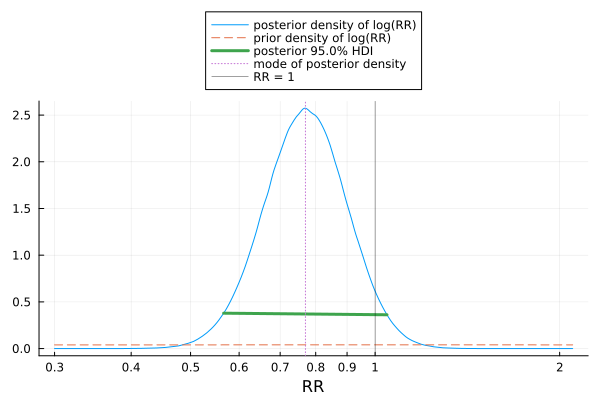

In [3]:
print_and_show_results_bayes(; prior_logRR=Normal(log(1.0), 10), xlim_RR=(0.3, 2.1))

prior data: [0 0; 0 0]
new data:   [44 80; 57 68]
posterior 95.0% confidence interval of RR = [0.5718, 1.053]
posterior point estimate (MLE) of RR = 0.7782


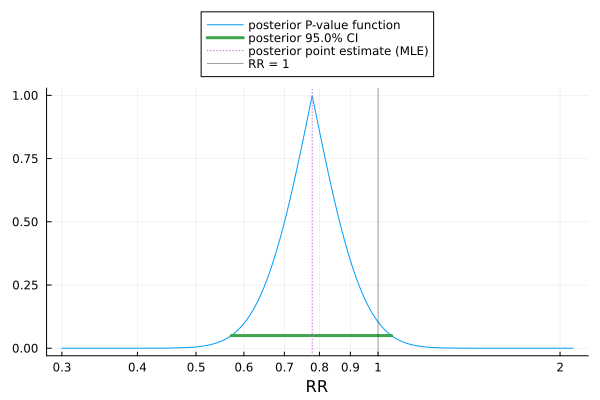

In [4]:
print_and_show_results_pvalue(; prior_data_setting=(RR0=1.0, n0=0), xlim_RR=(0.3, 2.1))

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


prior of log(RR): Normal{Float64}(μ=-0.40047756659712525, σ=0.25)
new data: [44 80; 57 68]
posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = (0.9891, 0.9309, 0.7198, 0.2248)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = (0.5691, 0.6774, 0.7411, 0.8097, 0.9575)
posterior 95.0% HDI = [0.5695, 0.958]
mode of posterior = 0.7475


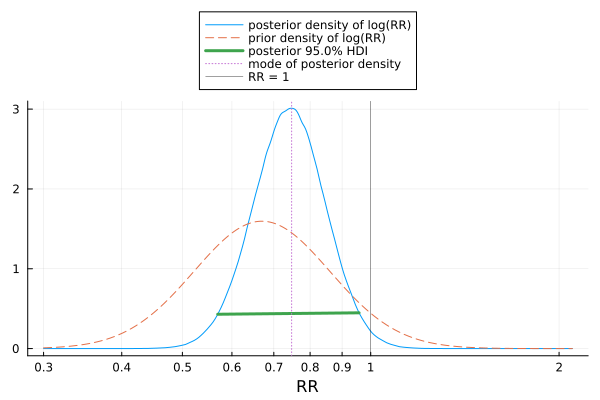

In [5]:
print_and_show_results_bayes(; prior_logRR=Normal(log(0.67), 0.25), xlim_RR=(0.3, 2.1))

prior data: [15 35; 23 27]
new data:   [44 80; 57 68]
posterior 95.0% confidence interval of RR = [0.5688, 0.9623]
posterior point estimate (MLE) of RR = 0.7417


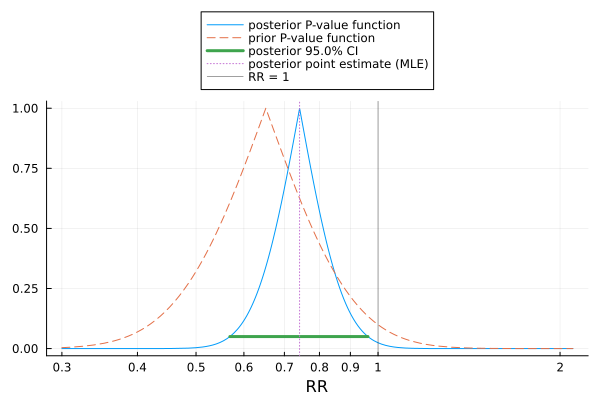

In [6]:
print_and_show_results_pvalue(; prior_data_setting=(RR0=0.67, n0=50), xlim_RR=(0.3, 2.1))

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:00


prior of log(RR): Normal{Float64}(μ=-0.2484613592984996, σ=0.15)
new data: [44 80; 57 68]
posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = (0.9911, 0.9176, 0.6124, 0.0881)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = (0.6272, 0.7212, 0.7757, 0.834, 0.957)
posterior 95.0% HDI = [0.6277, 0.9576]
mode of posterior = 0.7769


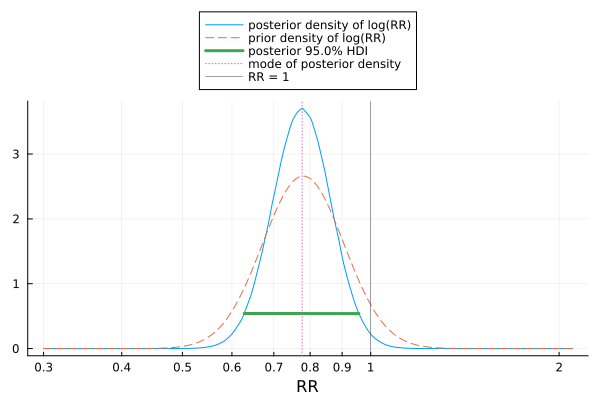

In [7]:
print_and_show_results_bayes(; prior_logRR=Normal(log(0.78), 0.15), xlim_RR=(0.3, 2.1))

prior data: [53 97; 68 82]
new data:   [44 80; 57 68]
posterior 95.0% confidence interval of RR = [0.633, 0.9555]
posterior point estimate (MLE) of RR = 0.7788


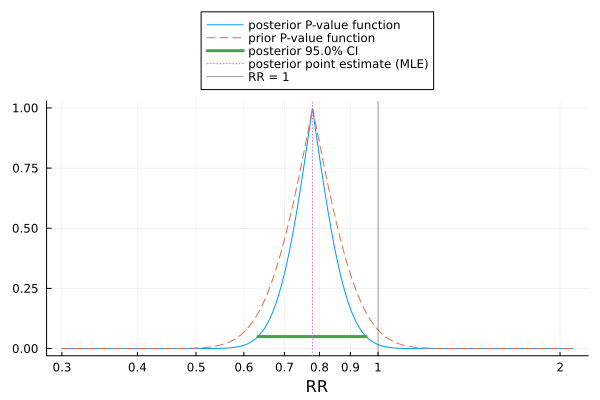

In [8]:
print_and_show_results_pvalue(; prior_data_setting=(RR0=0.78, n0=150), xlim_RR=(0.3, 2.1))

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


prior of log(RR): Normal{Float64}(μ=0.0, σ=0.24)
new data: [44 80; 57 68]
posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = (0.9237, 0.7291, 0.3822, 0.0487)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = (0.6437, 0.7622, 0.8318, 0.9073, 1.071)
posterior 95.0% HDI = [0.645, 1.073]
mode of posterior = 0.8222


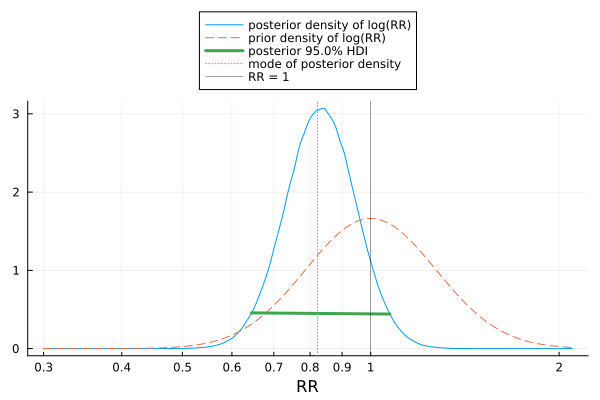

In [9]:
print_and_show_results_bayes(; prior_logRR=Normal(log(1.0), 0.24), xlim_RR=(0.3, 2.1))

prior data: [23 27; 23 27]
new data:   [44 80; 57 68]
posterior 95.0% confidence interval of RR = [0.6563, 1.078]
posterior point estimate (MLE) of RR = 0.8423


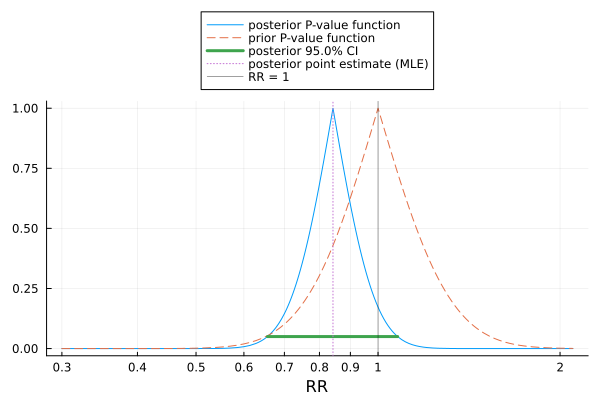

In [10]:
print_and_show_results_pvalue(; prior_data_setting=(RR0=1.0, n0=50), xlim_RR=(0.3, 2.1))

┌ Info: Found initial step size
└   ϵ = 0.049609375000000004
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.0125
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.0125
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


prior of log(RR): Normal{Float64}(μ=0.0, σ=0.15)
new data: [44 80; 57 68]
posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = (0.8828, 0.5798, 0.1843, 0.005492)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = (0.7135, 0.8194, 0.8808, 0.9466, 1.086)
posterior 95.0% HDI = [0.7154, 1.089]
mode of posterior = 0.8847


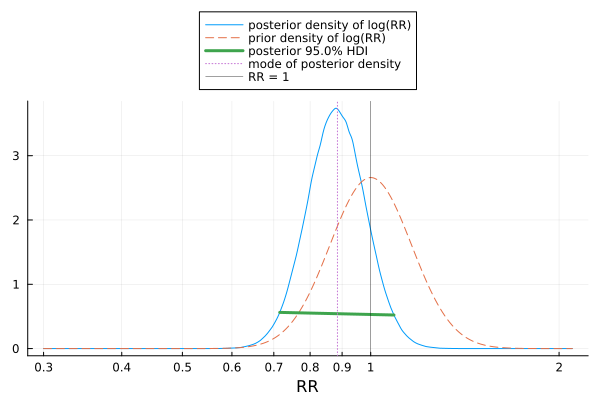

In [11]:
print_and_show_results_bayes(; prior_logRR=Normal(log(1.0), 0.15), xlim_RR=(0.3, 2.1))

prior data: [46 54; 46 54]
new data:   [44 80; 57 68]
posterior 95.0% confidence interval of RR = [0.7078, 1.086]
posterior point estimate (MLE) of RR = 0.8777


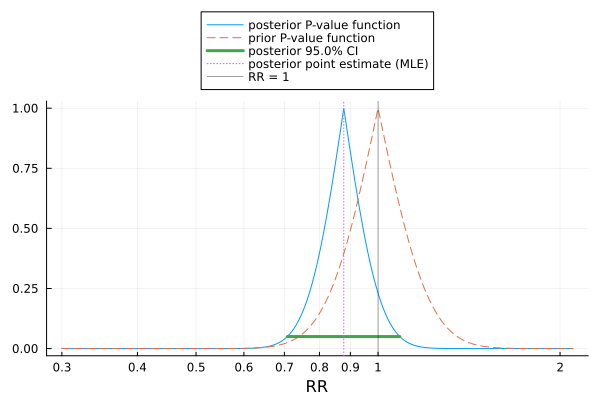

In [12]:
print_and_show_results_pvalue(; prior_data_setting=(RR0=1.0, n0=100), xlim_RR=(0.3, 2.1))

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


prior of log(RR): Normal{Float64}(μ=0.4054651081081644, σ=0.25)
new data: [44 80; 57 68]
posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = (0.7261, 0.4178, 0.1334, 0.006824)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = (0.7154, 0.8467, 0.9247, 1.01, 1.196)
posterior 95.0% HDI = [0.7155, 1.196]
mode of posterior = 0.9309


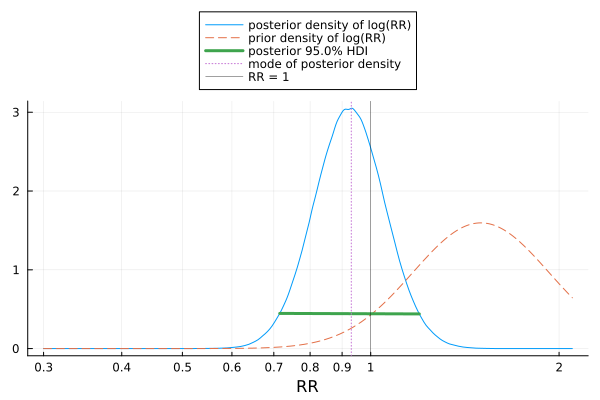

In [13]:
print_and_show_results_bayes(; prior_logRR=Normal(log(1.5), 0.25), xlim_RR=(0.3, 2.1))

prior data: [21 9; 14 16]
new data:   [44 80; 57 68]
posterior 95.0% confidence interval of RR = [0.7152, 1.185]
posterior point estimate (MLE) of RR = 0.9214


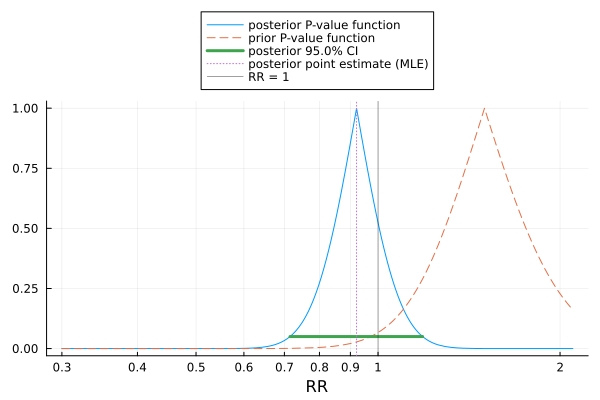

In [14]:
print_and_show_results_pvalue(; prior_data_setting=(RR0=1.5, n0=30), xlim_RR=(0.3, 2.1))

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.0125
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


prior of log(RR): Normal{Float64}(μ=0.1823215567939546, σ=0.15)
new data: [44 80; 57 68]
posterior probabilities of RR ≤ 1, 0.9, 0.8, 0.67 = (0.6268, 0.2525, 0.03872, 0.000346)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975) = (0.7833, 0.8992, 0.9663, 1.038, 1.192)
posterior 95.0% HDI = [0.7841, 1.193]
mode of posterior = 0.9612


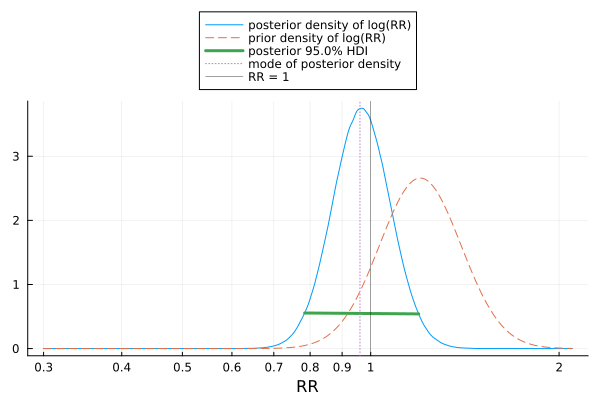

In [15]:
print_and_show_results_bayes(; prior_logRR=Normal(log(1.2), 0.15), xlim_RR=(0.3, 2.1))

prior data: [60 50; 50 60]
new data:   [44 80; 57 68]
posterior 95.0% confidence interval of RR = [0.7986, 1.193]
posterior point estimate (MLE) of RR = 0.9761


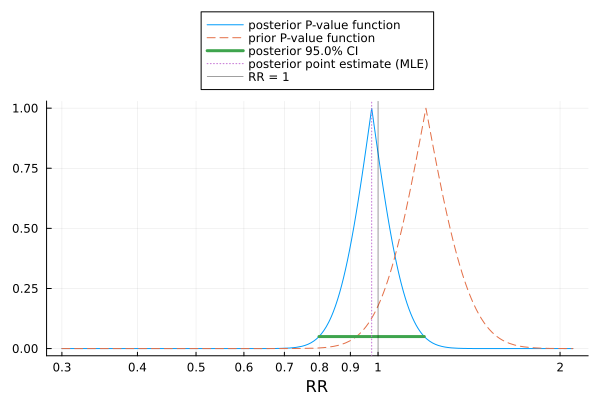

In [16]:
print_and_show_results_pvalue(; prior_data_setting=(RR0=1.2, n0=110), xlim_RR=(0.3, 2.1))